In [216]:
import cv2
import glob
import os
from matplotlib import pyplot as plt

## Brightness assesment algorithm

In [217]:
def create_colormap(path):
    avg = 0
    processed = 0
    for img_path in glob.iglob(f'{path}/*.JPG'):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([img], [2], None, [256], [0, 256])
        avg += hist
        processed += 1
    avg /= processed # normalization to one histogram
    cv2.normalize(avg,avg,0,255,cv2.NORM_MINMAX)
    return avg

# def create_colormap(path):
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     # [0, 1] - hue and saturation
#     hist = cv2.calcHist([img], [0, 1], None, [180, 256], [0, 180, 0, 256])
#     cv2.normalize(hist,hist,0,255,cv2.NORM_MINMAX)
#     return hist

def get_colormaps():
    light = create_colormap("./data/light")
    dark = create_colormap("./data/dark")
    normal = create_colormap("./data/normal")
    return light, dark, normal

def features_brightness(img_path):
    img = cv2.imread(img_path)
    cm_light, cm_dark, cm_normal = get_colormaps()
    rows,cols,_ = img.shape
    bp_light = cv2.calcBackProject([img], [2], cm_light, [0, 256], 1)
    bp_dark = cv2.calcBackProject([img], [2], cm_dark, [0, 256], 1)
    bp_normal = cv2.calcBackProject([img], [2], cm_normal, [0, 256], 1)
    cv2.normalize(bp_light, bp_light, 0, 255, cv2.NORM_MINMAX)
    cv2.normalize(bp_dark, bp_dark, 0, 255, cv2.NORM_MINMAX)
    cv2.normalize(bp_normal, bp_normal, 0, 255, cv2.NORM_MINMAX)
    CM1 = cv2.sumElems(bp_light)[0]/(rows*cols)
    CM2 = cv2.sumElems(bp_dark)[0]/(rows*cols)
    CM3 = cv2.sumElems(bp_normal)[0]/(rows*cols)
    return bp_light, bp_dark, bp_normal, CM1, CM2, CM3

The show_res_brightness function shows different stages and metrics of one image.

In [218]:
def show_res_brightness(img_path):
    im2, im3, im4, cm1, cm2, cm3 = features_brightness(img_path)
    im1 = cv2.imread(img_path)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
    im2 = cv2.cvtColor(im2, cv2.COLOR_GRAY2RGB)
    im3 = cv2.cvtColor(im3, cv2.COLOR_GRAY2RGB)
    im4 = cv2.cvtColor(im4, cv2.COLOR_GRAY2RGB)
    fig = plt.figure(figsize=(12, 10))
    fig.add_subplot(1, 4, 1)
    plt.imshow(im1)
    plt.axis('off') 
    plt.title("Původní obraz")
    fig.add_subplot(1, 4, 2)
    plt.imshow(im2)
    plt.axis('off') 
    plt.title("Zpětná projekce (světlé)")
    fig.add_subplot(1, 4, 3)
    plt.imshow(im3)
    plt.axis('off')
    plt.title("Zpětná projekce (tmavé)")
    fig.add_subplot(1, 4, 4)
    plt.imshow(im4)
    plt.axis('off')
    plt.title("Zpětná projekce (normální)")
    print("CM1: {:.2f}".format(cm1))
    print("CM2: {:.2f}".format(cm2))
    print("CM3: {:.2f}".format(cm3))


#### Examples of images

CM1: 185.16
CM2: 53.66
CM3: 53.62


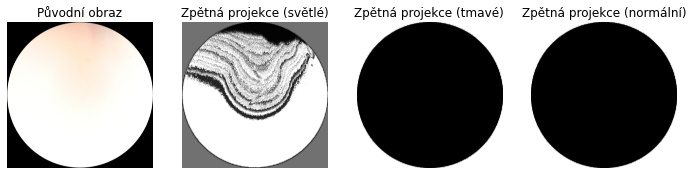

In [219]:
show_res_brightness("./data/light/012_F1_2642.JPG")

CM1: 54.89
CM2: 66.12
CM3: 55.38


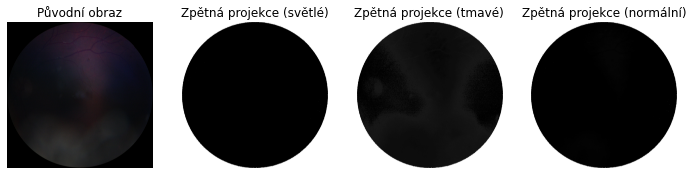

In [220]:
show_res_brightness("./data/dark/026_F1_2851.JPG")

CM1: 54.39
CM2: 57.09
CM3: 59.33


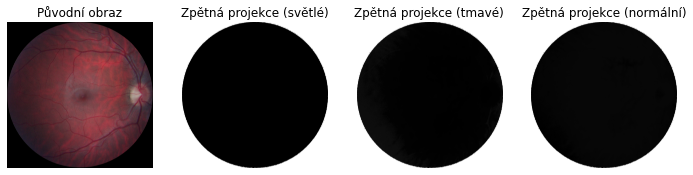

In [221]:
show_res_brightness("data/normal/046_R1_3103.JPG")

#### Algorithm validation

In [223]:
def validate_brightness(path):
    cm_light, cm_dark, cm_normal = get_colormaps()
    light = 0
    dark = 0
    normal = 0
    for img_path in glob.iglob(f'{path}/*.JPG'):
        _, _, _, cm1, cm2, cm3 = features_brightness(img_path)
        if cm1 > cm2 and cm1 > cm3:
            light += 1
        elif cm2 > cm1 and cm2 > cm3:
            dark += 1
        else:
            normal += 1
    return light, dark, normal

In [224]:
print("Light images validation:")
l, d, n = validate_brightness("./data/light")
print("Light: {}\nDark: {}\nNormal: {}".format(l, d, n))

print("Dark images validation:")
l, d, n = validate_brightness("./data/dark")
print("Light: {}\nDark: {}\nNormal: {}".format(l, d, n))

print("Normal images validation:")
l, d, n = validate_brightness("./data/normal")
print("Light: {}\nDark: {}\nNormal: {}".format(l, d, n))

Light images validation:


Light: 5
Dark: 0
Normal: 0
Dark images validation:
Light: 0
Dark: 5
Normal: 0
Normal images validation:
Light: 0
Dark: 0
Normal: 5
